# PFE: Modeliranje i Identifikacija Procesa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control
import warnings
warnings.filterwarnings("ignore")

np.random.seed(420)

### 1. Zadatak

Modelirati transfer funkciju sistema čiji je odskočni odziv dat na slici:

![Odziv](./src/odziv.png)

> Koristiti funkcije ```control``` biblioteke
>> [```control.TransferFunction```](https://python-control.readthedocs.io/en/latest/generated/control.TransferFunction.html) za generisanje prenoste funkcije\
>> [```control.step_response```](https://python-control.readthedocs.io/en/latest/generated/control.step_response.html) za generisanje odskočnog odziva date transfer funkcije

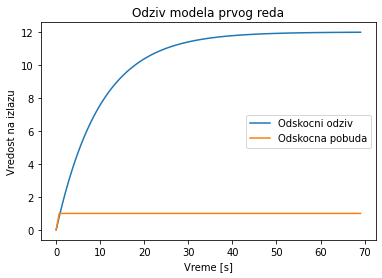

In [6]:
model = control.TransferFunction(12, [10, 1])
t, y = control.step_response(model)

step = np.ones(len(t))
step[0] = 0
plt.plot(t, y, label="Odskocni odziv")
plt.plot(t, step, label="Odskocna pobuda")
plt.title("Odziv modela prvog reda")
plt.xlabel("Vreme [s]")
plt.ylabel("Vredost na izlazu")
plt.legend()

plt.show()

Uneti u sistem fazno kašnenje od $T = 2s$. Fazno kašnjenje nije moguće implementirati direktno, zato se koristi aproksimacija prenosne funkcije uz pomoć [```control.pade```](https://python-control.readthedocs.io/en/latest/generated/control.pade.html) metorda.

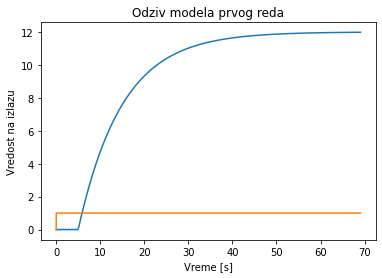

In [3]:
model = control.TransferFunction(12, [10, 1])

delay = control.pade(5, n = 20)
delay = control.TransferFunction(delay[0], delay[1])
t, y = control.step_response(model * delay)
step = np.ones(len(t))
step[0] = 0

plt.plot(t, y, label="Odziv")
plt.plot(t, step, label="Pobuda")
plt.title("Odziv modela prvog reda")
plt.xlabel("Vreme [s]")
plt.ylabel("Vredost na izlazu")
plt.legend()

plt.show()

Šta se dešava sa promenom reda polinoma estimacije eksponencijalne funkcije (previse veliki ili previse mali)? 

### 2. Zadatak

Implementirati metodu ```arx_model``` koja računa odziv ARX sistema definisanog $A$ i $B$ vektorima. Funkcija takođe na ulazu prima pobudu u vidu niza. 

In [4]:
def arx_model(A, B, u, e=None):
    broj_odbiraka = len(u)
    
    A = np.flip(-A[1:])
    B = np.flip(B)

    a = len(A)
    b = len(B)

    padding = np.zeros(a)
    if e is None:
        e = np.zeros(len(u))

    y = np.zeros(broj_odbiraka + a)
    u = np.concatenate([padding, u])
    e = np.concatenate([padding, e])

    for i in range(a, broj_odbiraka + a):
        y[i] = A @ y[i - a: i] + B @ u[i - b: i] + e[i]

    return y[a:]

Koristeći implementiranu funkciju ```arx_model``` simulirati odskočni odziv ARX sistema sa parametrima $ A = [1, -0.9]^T $ i $B = [1]$

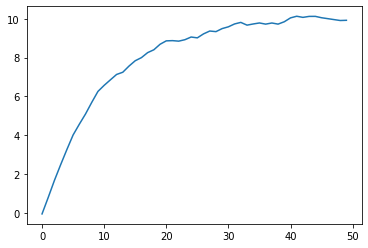

In [5]:
# Parametri modela

A = np.array([1, -0.9])
B = np.array([1])

n_samples = 50

u = np.ones(n_samples)
e = .08 * np.random.randn(n_samples)

y = arx_model(A, B, u, e)
plt.plot(y)

### 3. Zadatak

Identifikofati parametre sistema čiji odziv je moguće dobiti funcijom ``` nepoznati_model() ```.

Koristiti metodu najmanjih kvadrata:

![Formula](./src/least_squares.png)

Rešenje jednačine naći uz pomoć pseudo inverza: $\theta = (X^T \times X)^{-1} X^T \times Y$

**Note**: Unutar nepoznatog modela postoji šum

In [6]:
from nepoznati_model import nepoznati_model

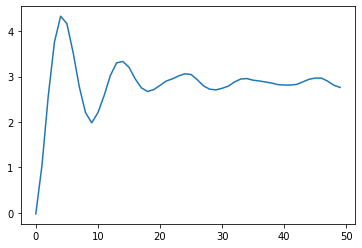

In [7]:
u = np.ones(50)
y = nepoznati_model(u)

plt.plot(y)
plt.show()

[-1.38162788  0.75187505  1.06747185]


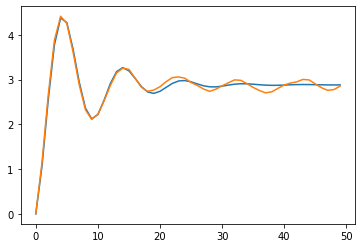

In [8]:
N = 50
u = np.ones(N)
y = nepoznati_model(u)

a_approx = 3
b_approx = 1

Y = []
X = []

for i in range(a_approx, N):
    
    Y.append(y[i])
    
    X.append(np.concatenate([
        np.flip(-y[i - a_approx+1: i]), np.flip(u[i - b_approx + 1: i + 1])
    ]))
    
X = np.array(X)
Y = np.array(Y)

theta = np.linalg.inv(X.T @ X) @ X.T @ Y

print(theta)
A_ = np.concatenate([[1], theta[:a_approx - 1]])
B_ = theta[a_approx - 1:]

n_samples = 50

u = np.ones(n_samples)
e = 0 * np.random.randn(n_samples)

y_ = arx_model(A_, B_, u, e)

plt.plot(y_)
plt.plot(y)
plt.show()

### 4. Zadatak

Identifikovati parametre arx modela iz funkcije ```napoznati_model``` uz pomoć globalne optimizacije parametara.

Koristiti diferencijalnu evoluciju iz ```scipy``` biblioteke.

[```differential_evolution```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) je funkcija koja prima dva ulaza: **funkciju_cene** i **granice_parametara**.

- Funkcija cene na ulazu treba da prima niz parametara modela, i da računa grešku u odnosu na odziv nepoznatog modela
- Granice parametara je lista uređenih parova, gde svaki par predstavlja donju i gornju granicu parametra

In [9]:
from scipy.optimize import differential_evolution

In [10]:
n_samples = 50

u = np.ones(n_samples)
gt = nepoznati_model(u)

def error_function(ulaz):
    a1, a2, b0 = ulaz
    A_ = np.array([1, a1, a2])
    B_ = np.array([b0])

    y_est = arx_model(A_, B_, u)

    return np.sum(np.square(gt - y_est))

x_min = -3
x_max = 3
xx = [(x_min, x_max), (x_min, x_max), (x_min, x_max)]
differential_evolution(error_function, bounds=xx)

     fun: 0.12373668230041543
     jac: array([-6.14924782e-06, -9.21485106e-06,  2.67702528e-06])
 message: 'Optimization terminated successfully.'
    nfev: 2424
     nit: 51
 success: True
       x: array([-1.33783743,  0.72686718,  1.1252179 ])

### 5. Globalna optimizacija za TF

Koristiti globalnu optimizaciju za identifikaciju parametara transfer funkcije iz prvog zadatka.

Šta se dešava ako loše pretpostavimo red modela?

In [11]:
# Mrzelo me dodradim

### 6. Zadatak

Iskoristiti višoslojnu regresorsku neuralnu mrežu ([```MLPRegressor```](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) kao model procesa, zatim je istrenirati na izlazima nepoznatog modela. 

In [ ]:
from sklearn.neural_network import MLPRegressor

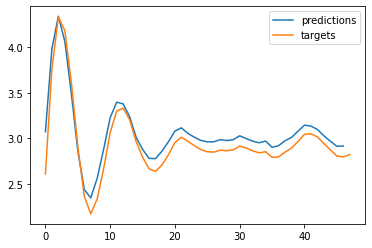

In [12]:
inputs = []
targets = []
a_approx = 3
b_approx = 1

gt = nepoznati_model(u)

for i in range(a_approx, N):

    targets.append(gt[i])
    inputs.append(np.concatenate([
        gt[i - a_approx+1: i], u[i - b_approx + 1: i + 1]
    ]))

inputs = np.array(inputs)
targets = np.array(targets)

regr = MLPRegressor(random_state=69, hidden_layer_sizes=[], max_iter=12000, solver="sgd", tol=1e-7, learning_rate="adaptive").fit(inputs, targets)
out = regr.predict(inputs)
out_padded = np.concatenate([np.zeros(a_approx), out])

plt.plot(out, label="predictions")
plt.plot(gt[a_approx-1:], label="targets")
plt.legend()
plt.show()